# Brent Smith Python Code for Project 2

In [1]:
import csv
import keras
import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.eval_measures import rmse
from keras.models import Sequential
from keras.layers import Dense, Activation

# Data Preprocessing

In [2]:
df = pd.read_csv("clean_Seoul.csv")

# date_time does not work well currently, parse individual sections of it and create columns for it.
def parse_timestamp(df, Date_Hour):
    df[Date_Hour] = pd.to_datetime(df[Date_Hour])
    df['Year'] = df[Date_Hour].dt.year
    df['Month'] = df[Date_Hour].dt.month
    df['Weekday'] = df[Date_Hour].dt.weekday
    df['Hour'] = df[Date_Hour].dt.hour
#This allows us to use each time section as its own feature. Hours we can see rush hour traffic, weekday to see vs weekends    
parse_timestamp(df, 'Date_Hour')

df.drop(columns = ['Date_Hour'], inplace = True)
df.drop(columns = ['Seasons_Spring'], inplace = True)

df.head()

,Rented Bike Count,Temperature (C),Humidity (%),Wind speed (m/s),Visibility (10m),Dew point temperature (C),Solar Radiation (MJ/m2),Rainfall (mm),Snowfall (cm),Holiday,Functioning Day,Seasons_Autumn,Seasons_Summer,Seasons_Winter,Year,Month,Weekday,Hour
0,254,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,0,1,0,0,1,2017,12,4,0
1,204,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,0,1,0,0,1,2017,12,4,1
2,173,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,0,1,0,0,1,2017,12,4,2
3,107,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,0,1,0,0,1,2017,12,4,3
4,78,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,0,1,0,0,1,2017,12,4,4


# Exploratory Data

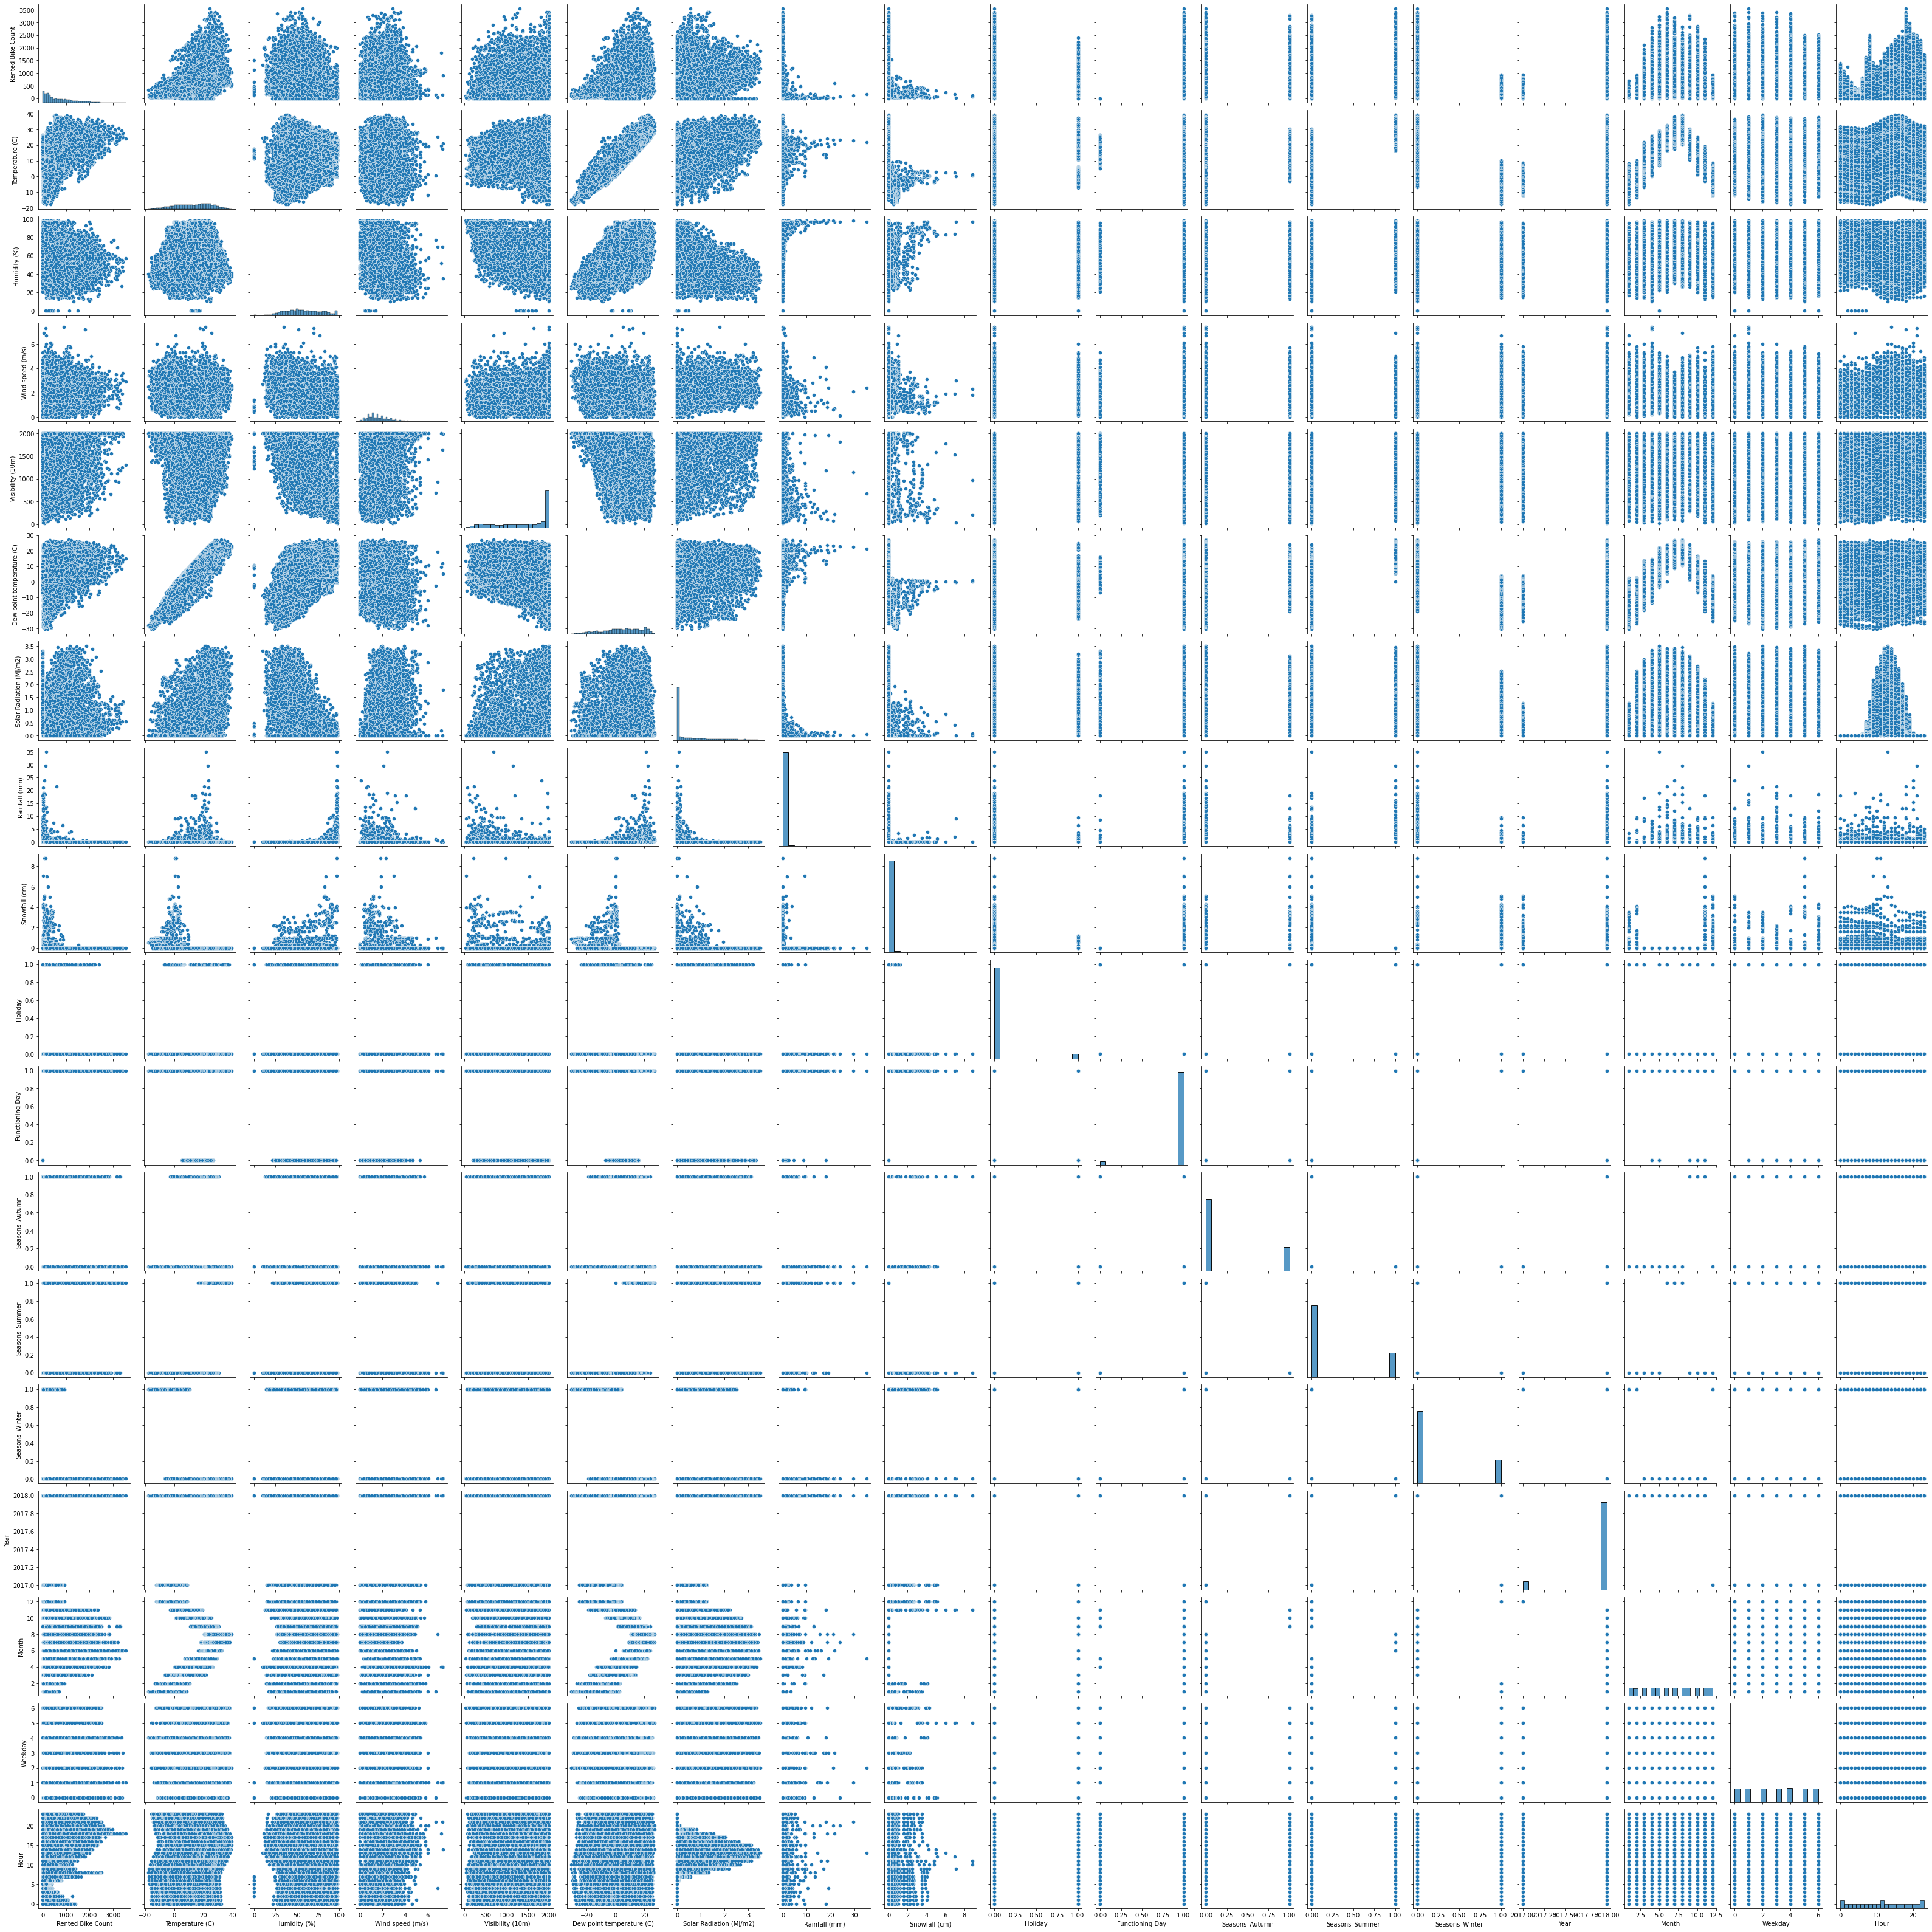

In [6]:
sns.pairplot(df)

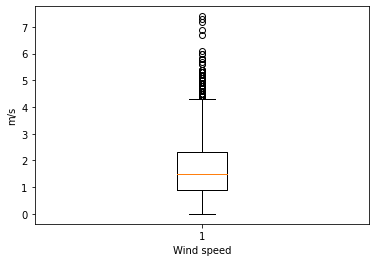

In [7]:
plt.boxplot(df['Wind speed (m/s)'])
plt.xlabel("Wind speed")
plt.ylabel("m/s")
df['Wind speed (m/s)'].describe()
df = df[df['Wind speed (m/s)'] < 4.4]
plt.show()

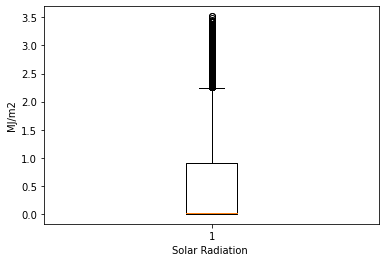

In [8]:
plt.boxplot(df['Solar Radiation (MJ/m2)'])
plt.xlabel("Solar Radiation ")
plt.ylabel("MJ/m2")
df['Solar Radiation (MJ/m2)'].describe()
df = df[df['Solar Radiation (MJ/m2)'] < 2.25]

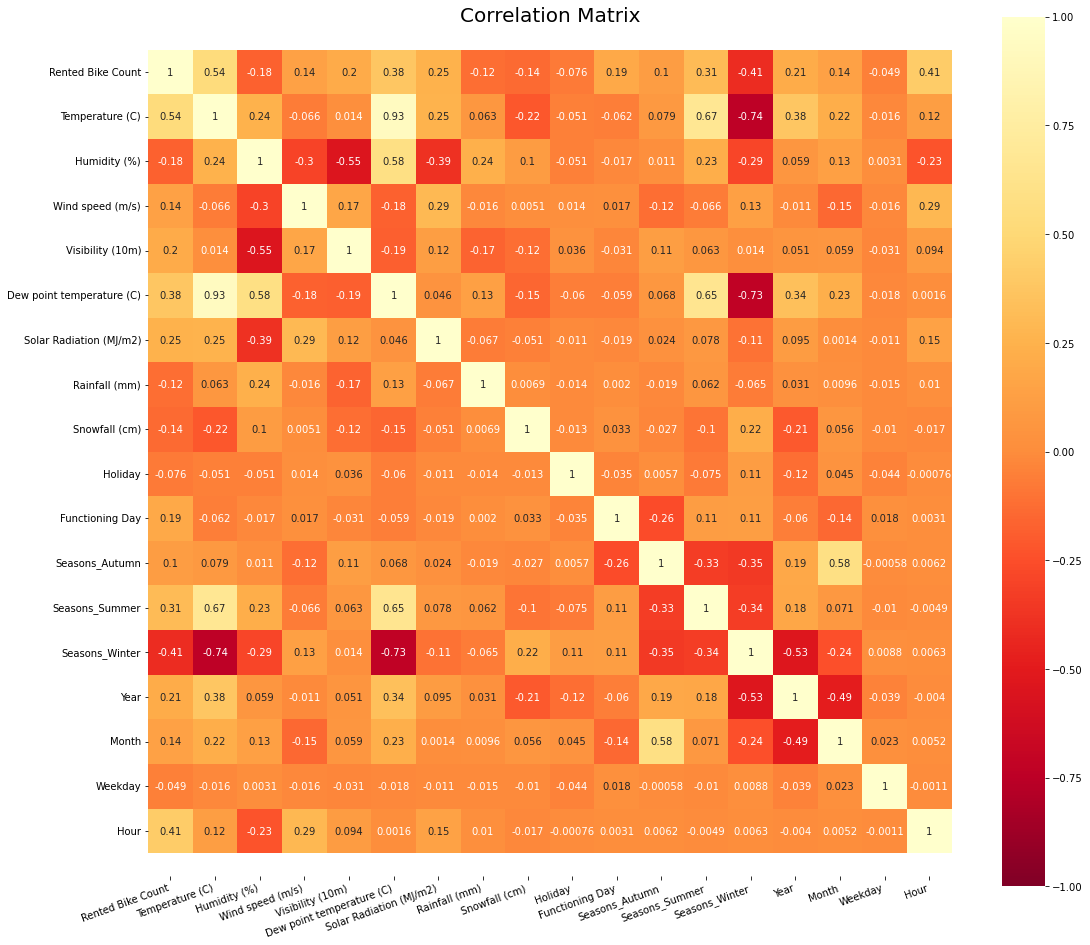

In [9]:
corr = df.corr()
plt.figure(figsize=(18,16))
ax = sns.heatmap(corr,vmin=-1, vmax=1, center=0, cmap='YlOrRd_r',square=True,annot=True)
bottom,top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
ax.set_xticklabels(ax.get_xticklabels(), rotation=20, horizontalalignment='right')
ax.set_yticklabels(ax.get_yticklabels(), rotation=360)
ax.set_title('Correlation Matrix', fontsize=20)
plt.show()

# Feature Selection

In [3]:
# Pre-Removed Year, Functioning Day, Rainfall, and Snowfall for issues in Scatterplot analysis
# Removed Dew Point, Seasonal Dummies for Collinearity with Temperature
# Removed Weekday for low correlation + poor scatterplot with Y variable

# Set dependent variable (all numeric columns expect target) and independent variables (target)
X = df[['Temperature (C)', 'Humidity (%)', 'Wind speed (m/s)', 'Visibility (10m)', 'Dew point temperature (C)',
         'Solar Radiation (MJ/m2)', 'Rainfall (mm)', 'Snowfall (cm)', 'Holiday', 'Functioning Day', 
        'Seasons_Autumn', 'Seasons_Summer', 'Seasons_Winter', 'Year', 'Month', 'Weekday', 'Hour']]
Y = df[['Rented Bike Count']]

# Add a column of ones to an array ('const' column)
X = sm.add_constant(X)

from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import LassoCV
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
#define cross-validation method to evaluate model
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
#define model
model = LassoCV(cv=cv, n_jobs=-1)
#fit model
model.fit(X, Y)
#display lambda that produced the lowest test MSE
print(model.alpha_)

regr_lasso = linear_model.Lasso(alpha=80.04309032530203)
model = regr_lasso.fit(X, Y)
pred = regr_lasso.predict(X)
train_r2 = r2_score(Y, pred)
print("Ideal Alpha Used - PostCV")
print(f"Intercept: {model.intercept_}")
print(f"Coefficients: {model.coef_}")
print(train_r2)

# Features deemed unimportant using Lasso Cross-Validated
X.drop(columns = ['Wind speed (m/s)'], inplace = True)
X.drop(columns = ['Solar Radiation (MJ/m2)'], inplace = True)
X.drop(columns = ['Dew point temperature (C)'], inplace = True)
X.drop(columns = ['Rainfall (mm)'], inplace = True)
X.drop(columns = ['Snowfall (cm)'], inplace = True)
X.drop(columns = ['Holiday'], inplace = True)
X.drop(columns = ['Functioning Day'], inplace = True)
X.drop(columns = ['Seasons_Autumn'], inplace = True)
X.drop(columns = ['Seasons_Summer'], inplace = True)
X.drop(columns = ['Seasons_Winter'], inplace = True)
X.drop(columns = ['Year'], inplace = True)
X.drop(columns = ['Weekday'], inplace = True)
# Final Features: Temperature, Humidity, Visibility, Month, and Hour

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, shuffle=False, test_size=0.2)

D:\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1571: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


78.1789238282667
Ideal Alpha Used - PostCV
Intercept: [351.21741173]
Coefficients: [ 0.         25.36175561 -6.44894632 -0.          0.05765352  2.86207832
 -0.         -0.          0.         -0.          0.          0.
 -0.         -0.          0.          1.28618848 -0.         26.02241492]
0.4539033894342327


# 2-Layer Neural Network

In [4]:
import tensorflow_addons as tfa

D:\anaconda3\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.9.0 and strictly below 2.12.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.12.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


In [5]:
# Build the model
r_sq = tfa.metrics.r_square.RSquare()
model_2 = Sequential(name="simple_2_layer")
model_2.add(keras.Input(shape=(6,)))
model_2.add(keras.layers.Dense(units=1, activation='tanh'))
    
# optimizer can be "adam"
model_2.compile(optimizer='adam', loss='mse', # can be "mse"
                        metrics=[r_sq, tf.metrics.RootMeanSquaredError()])

model_2.fit(X_train,Y_train, epochs=200, validation_data=(X_test, Y_test))

loss, r_sq, rmse = model_2.evaluate(X_test, Y_test)
print(loss)
print(r_sq)
print(rmse)

Epoch 1/200
219/219 [==============================] - 2s 3ms/step - loss: 904626.5625 - r_square: -1.1282 - root_mean_squared_error: 951.1186 - val_loss: 950736.1250 - val_r_square: -1.5274 - val_root_mean_squared_error: 975.0570
Epoch 2/200
219/219 [==============================] - 0s 1ms/step - loss: 904626.6875 - r_square: -1.1282 - root_mean_squared_error: 951.1187 - val_loss: 950736.1250 - val_r_square: -1.5274 - val_root_mean_squared_error: 975.0570
Epoch 3/200
219/219 [==============================] - 0s 1ms/step - loss: 904626.5000 - r_square: -1.1282 - root_mean_squared_error: 951.1185 - val_loss: 950736.1250 - val_r_square: -1.5274 - val_root_mean_squared_error: 975.0570
Epoch 4/200
219/219 [==============================] - 0s 1ms/step - loss: 904626.6250 - r_square: -1.1282 - root_mean_squared_error: 951.1186 - val_loss: 950736.1250 - val_r_square: -1.5274 - val_root_mean_squared_error: 975.0570
Epoch 5/200
219/219 [==============================] - 0s 1ms/step - loss: 9

219/219 [==============================] - 0s 2ms/step - loss: 904626.3125 - r_square: -1.1282 - root_mean_squared_error: 951.1185 - val_loss: 950736.1250 - val_r_square: -1.5274 - val_root_mean_squared_error: 975.0570
Epoch 37/200
219/219 [==============================] - 0s 2ms/step - loss: 904626.6250 - r_square: -1.1282 - root_mean_squared_error: 951.1186 - val_loss: 950736.1250 - val_r_square: -1.5274 - val_root_mean_squared_error: 975.0570
Epoch 38/200
219/219 [==============================] - 0s 2ms/step - loss: 904626.6250 - r_square: -1.1282 - root_mean_squared_error: 951.1186 - val_loss: 950736.1250 - val_r_square: -1.5274 - val_root_mean_squared_error: 975.0570
Epoch 39/200
219/219 [==============================] - 0s 2ms/step - loss: 904626.6250 - r_square: -1.1282 - root_mean_squared_error: 951.1186 - val_loss: 950736.1250 - val_r_square: -1.5274 - val_root_mean_squared_error: 975.0570
Epoch 40/200
219/219 [==============================] - 0s 2ms/step - loss: 904626.43

219/219 [==============================] - 0s 2ms/step - loss: 904626.4375 - r_square: -1.1282 - root_mean_squared_error: 951.1185 - val_loss: 950736.1250 - val_r_square: -1.5274 - val_root_mean_squared_error: 975.0570
Epoch 72/200
219/219 [==============================] - 0s 1ms/step - loss: 904626.2500 - r_square: -1.1282 - root_mean_squared_error: 951.1184 - val_loss: 950736.1250 - val_r_square: -1.5274 - val_root_mean_squared_error: 975.0570
Epoch 73/200
219/219 [==============================] - 0s 1ms/step - loss: 904626.4375 - r_square: -1.1282 - root_mean_squared_error: 951.1185 - val_loss: 950736.1250 - val_r_square: -1.5274 - val_root_mean_squared_error: 975.0570
Epoch 74/200
219/219 [==============================] - 0s 1ms/step - loss: 904626.5000 - r_square: -1.1282 - root_mean_squared_error: 951.1185 - val_loss: 950736.1250 - val_r_square: -1.5274 - val_root_mean_squared_error: 975.0570
Epoch 75/200
219/219 [==============================] - 0s 2ms/step - loss: 904626.56

219/219 [==============================] - 0s 2ms/step - loss: 904626.7500 - r_square: -1.1282 - root_mean_squared_error: 951.1187 - val_loss: 950736.1250 - val_r_square: -1.5274 - val_root_mean_squared_error: 975.0570
Epoch 107/200
219/219 [==============================] - 0s 2ms/step - loss: 904626.2500 - r_square: -1.1282 - root_mean_squared_error: 951.1184 - val_loss: 950736.1250 - val_r_square: -1.5274 - val_root_mean_squared_error: 975.0570
Epoch 108/200
219/219 [==============================] - 0s 1ms/step - loss: 904626.6250 - r_square: -1.1282 - root_mean_squared_error: 951.1186 - val_loss: 950736.1250 - val_r_square: -1.5274 - val_root_mean_squared_error: 975.0570
Epoch 109/200
219/219 [==============================] - 0s 2ms/step - loss: 904626.5000 - r_square: -1.1282 - root_mean_squared_error: 951.1185 - val_loss: 950736.1250 - val_r_square: -1.5274 - val_root_mean_squared_error: 975.0570
Epoch 110/200
219/219 [==============================] - 0s 2ms/step - loss: 90462

219/219 [==============================] - 0s 1ms/step - loss: 904626.4375 - r_square: -1.1282 - root_mean_squared_error: 951.1185 - val_loss: 950736.1250 - val_r_square: -1.5274 - val_root_mean_squared_error: 975.0570
Epoch 142/200
219/219 [==============================] - 0s 1ms/step - loss: 904626.5000 - r_square: -1.1282 - root_mean_squared_error: 951.1185 - val_loss: 950736.1250 - val_r_square: -1.5274 - val_root_mean_squared_error: 975.0570
Epoch 143/200
219/219 [==============================] - 0s 1ms/step - loss: 904626.6875 - r_square: -1.1282 - root_mean_squared_error: 951.1187 - val_loss: 950736.1250 - val_r_square: -1.5274 - val_root_mean_squared_error: 975.0570
Epoch 144/200
219/219 [==============================] - 0s 2ms/step - loss: 904626.5000 - r_square: -1.1282 - root_mean_squared_error: 951.1185 - val_loss: 950736.1250 - val_r_square: -1.5274 - val_root_mean_squared_error: 975.0570
Epoch 145/200
219/219 [==============================] - 0s 1ms/step - loss: 90462

219/219 [==============================] - 0s 1ms/step - loss: 904626.2500 - r_square: -1.1282 - root_mean_squared_error: 951.1184 - val_loss: 950736.1250 - val_r_square: -1.5274 - val_root_mean_squared_error: 975.0570
Epoch 177/200
219/219 [==============================] - 0s 1ms/step - loss: 904626.4375 - r_square: -1.1282 - root_mean_squared_error: 951.1185 - val_loss: 950736.1250 - val_r_square: -1.5274 - val_root_mean_squared_error: 975.0570
Epoch 178/200
219/219 [==============================] - 0s 2ms/step - loss: 904626.6250 - r_square: -1.1282 - root_mean_squared_error: 951.1186 - val_loss: 950736.1250 - val_r_square: -1.5274 - val_root_mean_squared_error: 975.0570
Epoch 179/200
219/219 [==============================] - 0s 1ms/step - loss: 904626.7500 - r_square: -1.1282 - root_mean_squared_error: 951.1187 - val_loss: 950736.1250 - val_r_square: -1.5274 - val_root_mean_squared_error: 975.0570
Epoch 180/200
219/219 [==============================] - 0s 1ms/step - loss: 90462

#  3-Layered Neural Network

In [36]:
# Build the model
r_sq = tfa.metrics.r_square.RSquare()
model_3 = Sequential(name="simple_3_layer")
model_3.add(keras.Input(shape=(6,)))
model_3.add(keras.layers.Dense(units=13, activation='relu'))
model_3.add(keras.layers.Dense(units=7, activation='relu'))
model_3.add(keras.layers.Dense(units=1, activation='linear'))

# optimizer can be "adam"
model_3.compile(optimizer='adam', loss='mse', # can be "mse"
                        metrics=[r_sq, tf.metrics.RootMeanSquaredError()])

model_3.fit(X_train,Y_train, epochs=50, validation_data=(X_test, Y_test))

loss, r_sq, rmse = model_3.evaluate(X_test, Y_test)
print(loss)
print(r_sq)
print(rmse)

Epoch 1/50
198/198 [==============================] - 1s 2ms/step - loss: 458355.6875 - r_square: -0.0261 - root_mean_squared_error: 677.0197 - val_loss: 385251.6562 - val_r_square: -0.0376 - val_root_mean_squared_error: 620.6865
Epoch 2/50
198/198 [==============================] - 0s 2ms/step - loss: 439400.5000 - r_square: 0.0163 - root_mean_squared_error: 662.8729 - val_loss: 381241.3125 - val_r_square: -0.0268 - val_root_mean_squared_error: 617.4474
Epoch 3/50
198/198 [==============================] - 0s 2ms/step - loss: 429745.1562 - r_square: 0.0379 - root_mean_squared_error: 655.5495 - val_loss: 377720.4375 - val_r_square: -0.0173 - val_root_mean_squared_error: 614.5897
Epoch 4/50
198/198 [==============================] - 0s 2ms/step - loss: 416998.5938 - r_square: 0.0665 - root_mean_squared_error: 645.7543 - val_loss: 373448.2500 - val_r_square: -0.0058 - val_root_mean_squared_error: 611.1041
Epoch 5/50
198/198 [==============================] - 0s 2ms/step - loss: 401343.53

Epoch 37/50
198/198 [==============================] - 0s 2ms/step - loss: 197711.3125 - r_square: 0.5574 - root_mean_squared_error: 444.6474 - val_loss: 292232.7500 - val_r_square: 0.2129 - val_root_mean_squared_error: 540.5856
Epoch 38/50
198/198 [==============================] - 0s 2ms/step - loss: 197348.2188 - r_square: 0.5582 - root_mean_squared_error: 444.2389 - val_loss: 282638.8125 - val_r_square: 0.2388 - val_root_mean_squared_error: 531.6379
Epoch 39/50
198/198 [==============================] - 0s 1ms/step - loss: 197575.2188 - r_square: 0.5577 - root_mean_squared_error: 444.4944 - val_loss: 285151.6250 - val_r_square: 0.2320 - val_root_mean_squared_error: 533.9959
Epoch 40/50
198/198 [==============================] - 0s 1ms/step - loss: 197537.7500 - r_square: 0.5578 - root_mean_squared_error: 444.4522 - val_loss: 297730.2812 - val_r_square: 0.1981 - val_root_mean_squared_error: 545.6467
Epoch 41/50
198/198 [==============================] - 0s 2ms/step - loss: 197472.78

In [40]:
model_3.predict(X_test)

50/50 [==============================] - 0s 861us/step


array([[588.79846],
       [794.7509 ],
       [989.7488 ],
       ...,
       [567.7357 ],
       [581.6305 ],
       [595.08154]], dtype=float32)

# 4-Layered Neural Network

In [37]:
# Build the model
r_sq = tfa.metrics.r_square.RSquare()
model_4 = Sequential(name="simple_4_layer")
model_4.add(keras.Input(shape=(6,)))
model_4.add(keras.layers.Dense(units=13, activation='relu'))
model_4.add(keras.layers.Dense(units=7, activation='relu'))
model_4.add(keras.layers.Dense(units=4, activation='relu'))
model_4.add(keras.layers.Dense(units=1, activation='linear'))
    
model_4.compile(optimizer='adam', loss='mse', # can be "mse"
                        metrics=[r_sq, tf.metrics.RootMeanSquaredError()])

model_4.fit(X_train,Y_train, epochs=50, validation_data=(X_test, Y_test))

loss, r_sq, rmse = model_4.evaluate(X_test, Y_test)
print(loss)
print(r_sq)
print(rmse)

Epoch 1/50
198/198 [==============================] - 1s 2ms/step - loss: 636084.8750 - r_square: -0.4240 - root_mean_squared_error: 797.5493 - val_loss: 388599.1875 - val_r_square: -0.0466 - val_root_mean_squared_error: 623.3773
Epoch 2/50
198/198 [==============================] - 0s 2ms/step - loss: 440260.3125 - r_square: 0.0144 - root_mean_squared_error: 663.5211 - val_loss: 384653.0938 - val_r_square: -0.0360 - val_root_mean_squared_error: 620.2041
Epoch 3/50
198/198 [==============================] - 0s 2ms/step - loss: 432752.3438 - r_square: 0.0312 - root_mean_squared_error: 657.8392 - val_loss: 381183.8438 - val_r_square: -0.0266 - val_root_mean_squared_error: 617.4009
Epoch 4/50
198/198 [==============================] - 0s 2ms/step - loss: 422834.3125 - r_square: 0.0534 - root_mean_squared_error: 650.2571 - val_loss: 378263.3125 - val_r_square: -0.0188 - val_root_mean_squared_error: 615.0311
Epoch 5/50
198/198 [==============================] - 0s 2ms/step - loss: 410818.96

Epoch 37/50
198/198 [==============================] - 0s 2ms/step - loss: 188127.6719 - r_square: 0.5788 - root_mean_squared_error: 433.7369 - val_loss: 285704.2500 - val_r_square: 0.2305 - val_root_mean_squared_error: 534.5131
Epoch 38/50
198/198 [==============================] - 0s 2ms/step - loss: 186126.2031 - r_square: 0.5833 - root_mean_squared_error: 431.4235 - val_loss: 304836.0625 - val_r_square: 0.1790 - val_root_mean_squared_error: 552.1196
Epoch 39/50
198/198 [==============================] - 0s 2ms/step - loss: 186051.5781 - r_square: 0.5835 - root_mean_squared_error: 431.3370 - val_loss: 288233.5000 - val_r_square: 0.2237 - val_root_mean_squared_error: 536.8738
Epoch 40/50
198/198 [==============================] - 0s 2ms/step - loss: 185006.2188 - r_square: 0.5858 - root_mean_squared_error: 430.1235 - val_loss: 282321.9688 - val_r_square: 0.2396 - val_root_mean_squared_error: 531.3398
Epoch 41/50
198/198 [==============================] - 0s 2ms/step - loss: 184251.46

In [39]:
model_4.predict(X_test)

50/50 [==============================] - 0s 814us/step


array([[ 635.90265],
       [ 850.0174 ],
       [1096.1229 ],
       ...,
       [ 719.56903],
       [ 707.2524 ],
       [ 717.97626]], dtype=float32)